# Loan Status Prediction

## Introduction


In this project, I performe data analysis and predictive modelling on Lending Club's loan data set for the year 2015 in order to understand how different set of features help to indentify customer loan status. This can potentially  

## Lending Club Data

Lending Club is one of the America's largest lending companies that allows borrowers
to apply and obtain personal loans, auto refinancing, business loans, and elective medical procedures.
Additionally, they make some of their data publically available.  


![title](https://getbackonfeet.com/wp-content/uploads/2018/10/000-2-1.png)

## ETL Pipline

1. **Data Cleaning**:

    * Drop irrelevant features
    * Clean mixed type features
    * ....

2. **Exploratory Analysis**


3. **Machine Learning** 
    * Feature Normalization
    * Train Test Split
    * Cross Validation
    * ML Prediction
    


### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

#plotly
from plotly.plotly import iplot
import plotly.graph_objs as go

from src.utility import *
from src.plotting import *
from src.ml_models import *

%matplotlib inline  
import warnings
warnings.filterwarnings("ignore")

## Loan Data

In [2]:
keep_cols = ["loan_status","loan_amnt", "term","int_rate","installment","grade",
             "sub_grade","purpose","emp_length","home_ownership","annual_inc",
             "verification_status","issue_d","dti","earliest_cr_line","open_acc",
             "revol_bal","revol_util","total_acc"]

df_orig = pd.read_csv("data/loan.csv", usecols=keep_cols,skipfooter=4,skiprows=1)#,low_memory=False)

In [3]:
df = df_orig
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421095 entries, 0 to 421094
Data columns (total 19 columns):
loan_amnt              421095 non-null int64
term                   421095 non-null object
int_rate               421095 non-null object
installment            421095 non-null float64
grade                  421095 non-null object
sub_grade              421095 non-null object
emp_length             397278 non-null object
home_ownership         421095 non-null object
annual_inc             421095 non-null float64
verification_status    421095 non-null object
issue_d                421095 non-null object
loan_status            421095 non-null object
purpose                421095 non-null object
dti                    421093 non-null float64
earliest_cr_line       421095 non-null object
open_acc               421095 non-null int64
revol_bal              421095 non-null int64
revol_util             420933 non-null object
total_acc              421095 non-null int64
dtypes: float64(

In [4]:
df.tail()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,dti,earliest_cr_line,open_acc,revol_bal,revol_util,total_acc
421090,10000,36 months,11.99%,332.10,B,B5,8 years,RENT,31000.0,Verified,Jan-2015,Fully Paid,debt_consolidation,28.69,Sep-2004,9,14037,82.1%,15
421091,24000,36 months,11.99%,797.03,B,B5,10+ years,MORTGAGE,79000.0,Verified,Jan-2015,Fully Paid,home_improvement,3.90,Mar-1974,5,8621,84.5%,23
421092,12000,60 months,19.99%,317.86,E,E3,1 year,RENT,64400.0,Source Verified,Jan-2015,Charged Off,debt_consolidation,27.19,Oct-2003,17,8254,30.6%,20
421093,13000,60 months,15.99%,316.07,D,D2,5 years,RENT,35000.0,Verified,Jan-2015,Charged Off,debt_consolidation,30.90,Sep-2003,9,11031,61.3%,22
421094,20000,36 months,11.99%,664.20,B,B5,10+ years,RENT,100000.0,Verified,Jan-2015,Fully Paid,credit_card,10.83,Dec-2001,8,33266,79.8%,10


There were overall 145 features and most of them were irrelevant. So we keep most important features for further processing that reduces memory usage and improves performance.

### Fix Target Feature

In [5]:
# simplify target feature
df.loan_status.value_counts()

Fully Paid            296634
Charged Off            74762
Current                46461
Late (31-120 days)      1819
In Grace Period          980
Late (16-30 days)        434
Default                    5
Name: loan_status, dtype: int64

Target feature 'loan_status' has 7 factors. We will reduce it to two 'Good' and 'Bad' loans.

In [6]:
good_loans = ['Fully Paid', 'Current']

def ChangeStatus(status):
    if status in good_loans:
        return 'Good Loan'
    else:
        return 'Bad Loan'
tmp = df['loan_status'].apply(ChangeStatus)
df.loan_status = tmp

### Clean Features

Some features have mixed type such as number mixed with string.

* Remove '%' from 'int_rate', 'revol_util' 
* Replace all 'n/a' with np.nan
* Extract numeric part of employment length
* Save name of the loan issued month
* Get credita agae from issue data and earliest credit line
* Again drop some unnecessary columns

In [7]:
df = CleanData(df)
df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,dti,open_acc,revol_bal,revol_util,total_acc,issue_month,cred_age
0,24700,36,11.99,820.28,C,C1,10,MORTGAGE,65000.0,Not Verified,Good Loan,small_business,16.06,22,21470,19.2,38,Dec,16.0
1,17925,60,17.27,448.09,D,D3,10,OWN,39000.0,Source Verified,Good Loan,debt_consolidation,27.78,10,19614,76.0,21,Dec,13.0
2,9000,36,8.49,284.07,B,B1,8,MORTGAGE,47000.0,Not Verified,Good Loan,debt_consolidation,8.43,12,9747,26.7,22,Dec,15.0
3,11550,60,16.59,284.51,D,D2,5,RENT,38000.0,Not Verified,Bad Loan,credit_card,21.07,9,7179,39.7,12,Dec,5.0
4,12000,60,9.80,253.79,B,B3,10,MORTGAGE,65000.0,Not Verified,Good Loan,debt_consolidation,23.84,18,9786,13.4,37,Dec,12.0


In [8]:
#statistics of numeric features
df.describe().iloc[[1,2,3,7],:].round(1)

,loan_amnt,term,int_rate,installment,emp_length,annual_inc,dti,open_acc,revol_bal,revol_util,total_acc,cred_age
mean,15240.3,43.9,12.6,441.8,5.8,76965.6,19.1,11.9,17685.5,53.8,25.5,16.8
std,8571.3,11.3,4.3,244.8,3.8,73950.0,8.9,5.6,24195.0,23.9,12.1,7.6
min,1000.0,36.0,5.3,14.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0,3.0
max,35000.0,60.0,29.0,1445.5,10.0,9500000.0,999.0,90.0,2904836.0,193.0,169.0,71.0


### Loan Status & Amount

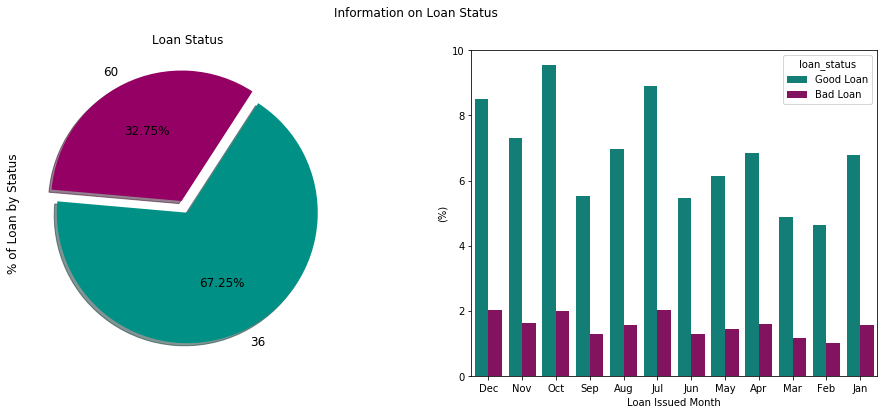

In [9]:
plotLoanStat1(df,colors = ColorList([11,12]))

* Based on fraction of 'Good' and 'Bad' loans, we don't have data imbalance problem.
* Percentage of issued loans seem to reduce as year ending!

In [10]:
df.purpose.value_counts()

debt_consolidation    250020
credit_card           102025
home_improvement       25293
other                  19204
major_purchase          7449
medical                 3938
car                     3466
small_business          3364
moving                  2420
vacation                2249
house                   1438
renewable_energy         224
wedding                    4
educational                1
Name: purpose, dtype: int64

In [11]:
ave_good_loan_by_purpose = df[df.loan_status == 'Good Loan'].groupby('purpose').loan_amnt.mean().astype(int)
ave_bad_loan_by_purpose = df[df.loan_status == 'Bad Loan'].groupby('purpose').loan_amnt.mean().astype(int)

good_bars = go.Bar(
    x = list(ave_good_loan_by_purpose.index),
    y = list(ave_good_loan_by_purpose.values),
    name='Good Loans',
    text='%',
    marker=dict(
        color='rgba(50, 171, 96, 0.7)',
        line = dict(
            color='rgba(50, 171, 96, 1.0)',
            width=2
        )
    )
)


bad_bars = go.Bar(
    x = list(ave_bad_loan_by_purpose.index),
    y = list(ave_bad_loan_by_purpose.values),
    name = 'Bad Loans',
    text='%',
    marker=dict(
        color='rgba(219,64,82,0.7)',
        line = dict(
            color='rgba(219, 64, 82, 1.0)',
            width=2
        )
    )
)

data = [good_bars, bad_bars]

layout = go.Layout(
    title='Average Amount of Loan given for Different Purposes Classified by Loan Status',
    xaxis=dict(
        title=''
    ),
    yaxis=dict(
        title='Average Loan Amount',
    ),
    paper_bgcolor='rgba(250,200,200,0.3)',
    plot_bgcolor='rgba(250,200,200,0.3)',
    showlegend=True
)

fig = dict(data=data, layout=layout)
iplot(fig)


### Let's  look at how features are correlated

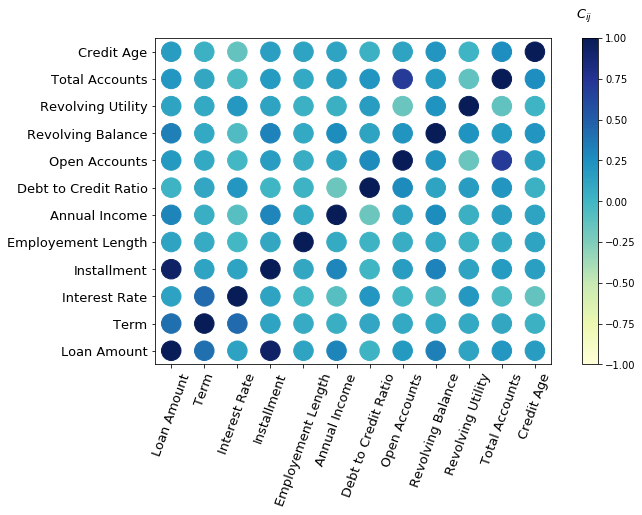

In [12]:
cor = df.corr()
corr_names = ['Loan Amount', 'Term', 'Interest Rate', 'Installment', 'Employement Length',
              'Annual Income', 'Debt to Credit Ratio', 'Open Accounts', 'Revolving Balance',
              'Revolving Utility', 'Total Accounts','Credit Age']

cmap = "YlGnBu"
plt.figure(figsize=(9,6))
CPlot(corr_mat = cor.values, axis_labs = corr_names,cmap = cmap,
      pad = 0.05,rad = 380, xlab = '',ylab = '',fs = 13,
      xtick_lab_rot = 70)

'loan_amnt' and 'installment' are highly correlated

## Interest Rate

Sort 'grade' and 'sub_grade' in alphabetic order and check how interest rate varies across different grades.

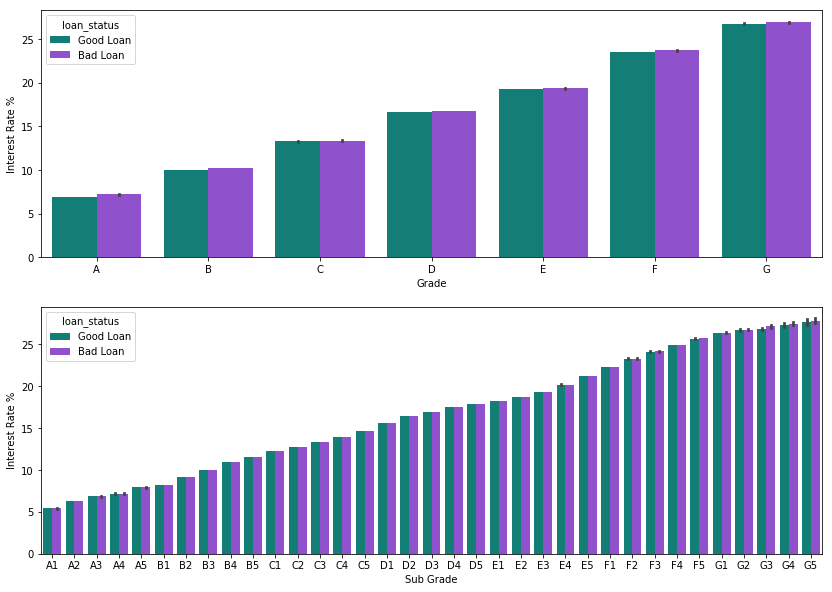

In [14]:
colors = ColorList([11,1])
plotLoanStat2(df,colors)

sdfsdfffffffffffff

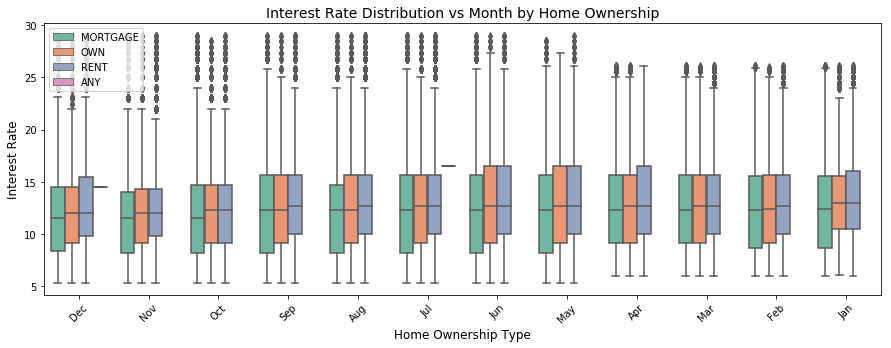

In [15]:
plotLoanStat3(df)

### Bla Bla

In [16]:
ave_good_loan_by_grade = df[df.loan_status == 'Good Loan'].groupby('grade',axis=0).loan_amnt.mean().astype(int)
ave_bad_loan_by_grade = df[df.loan_status == 'Bad Loan'].groupby('grade',axis=0).loan_amnt.mean().astype(int)

#prepare data for plotly
data = [
    go.Scatterpolar(mode='lines+markers',
        r = list(ave_good_loan_by_grade.values),
        theta = list(ave_good_loan_by_grade.index),
        fill = 'toself',
        name = 'Good Loans',
        line = dict(color = "#63AF63"),
        marker = dict(color = "#B3FFB3",symbol = "square",size = 11),
        subplot = "polar1"),

    go.Scatterpolar(
        mode='lines+markers',
        r = list(ave_bad_loan_by_grade.values),
        theta = list(ave_bad_loan_by_grade.index),
        fill = 'toself', name = 'Bad Loans',
        line = dict(color = "#C31414"),
        marker = dict(color = "#FF5050",symbol = "square",size = 11),
        subplot = "polar2")
]

#define layout
layout = go.Layout(
    title="Average Good and Bad Loans by Grade",
    showlegend = False,
    paper_bgcolor = "rgb(255, 248, 243)",
    polar1 = dict(
        domain = dict(
        x = [0,0.4],
        y = [0,1]
      ),
      radialaxis = dict(
        tickfont = dict(
          size = 12
        )
      ),
      angularaxis = dict(
        tickfont = dict(
          size = 12
        ),
        rotation = 90,
        direction = "counterclockwise"
      )
    ),
    polar2 = dict(
      domain = dict(
        x = [0.6,1],
        y = [0,1]
      ),
      radialaxis = dict(
        tickfont = dict(
          size = 12
        )
      ),
      angularaxis = dict(
        tickfont = dict(
          size = 12
        ),
        rotation = 90,
        direction = "clockwise"
      ),
    )
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)